# Problem 1

## Data

In [1]:
import numpy as np

data = np.load("data/mnist.npz")
x_train, y_train = data["x_train"], data["y_train"]
x_test, y_test = data["x_test"], data["y_test"]

In [2]:
# reshape to vectors, change dtype from int8 to float32 and normalize [0,255] -> [0,1]
x_train = x_train.reshape(x_train.shape[0], -1).astype(np.float32) / 255
x_test = x_test.reshape(x_test.shape[0], -1).astype(np.float32) / 255

In [3]:
# create a validation set
from sklearn import model_selection

x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    x_train, y_train, test_size=10000, stratify=y_train)

## Building the Model

In [4]:
import math
import random


class Classifier(object):
    def __init__(self,
                 hidden_dims=(500, 250),
                 n_hidden=2,
                 mode="train",
                 datapath=None,
                 model_path=None):
        #weights and bias structure
        self.weights, self.bias = [], []
        #layer 1
        self.weights.append(np.empty((hidden_dims[0], 784)))
        self.bias.append(np.zeros((hidden_dims[0])))
        #hidden layer
        for i in range(n_hidden - 1):
            self.weights.append(np.empty((hidden_dims[i + 1], hidden_dims[i])))
            self.bias.append(np.zeros((hidden_dims[i + 1])))
        #output layer
        self.weights.append(np.empty((10, hidden_dims[-1])))
        self.bias.append(np.zeros((10)))

    def initialize_weights(self, method="glorot"):
        for i, w in enumerate(self.weights):
            if method is "glorot":
                d = math.sqrt(6 / (w.shape[0] + w.shape[1]))
                self.weights[i] = np.random.uniform(
                    low=-d, high=d, size=w.shape)
            if method is "normal":
                self.weights[i] = np.random.normal(
                    loc=0, scale=1, size=w.shape)
            if method is "zero":
                self.weights[i] = np.zeros(shape=w.shape)

    def forward(self, input):
        self.cache = [input]
        for W, b in zip(self.weights, self.bias):
            self.cache.append(self.activation(W @ self.cache[-1] + b))
        return self.softmax(self.cache.pop())

    def activation(self, input):
        return np.maximum(0, input)

    def loss(self, prediction, label):
        return -math.log(self.softmax(prediction)[label])

    def softmax(self, input):
        m = np.max(input)
        return np.exp(input - m) / np.sum(np.exp(input - m))

    def backward(self, output, label):
        grad_pre_activation = np.asarray([
            out - 1 if i == label else out for i, out in enumerate(output)
        ]).reshape(-1, 1)
        self.grad_w, self.grad_b = [], []
        # we go from the last layer to the first one
        for i, (w, b) in enumerate(
                zip(reversed(self.weights), reversed(self.bias))):
            previous_hidden_layer = np.asarray(list(reversed(self.cache))[i])
            self.grad_w.insert(
                0,
                grad_pre_activation @ previous_hidden_layer.reshape(-1, 1).T)
            self.grad_b.insert(0, grad_pre_activation.reshape(-1))
            grad_previous_hidden_layer = w.T @ grad_pre_activation
            grad_pre_activation = grad_previous_hidden_layer * np.asarray(
                [1 if x > 0 else 0
                 for x in list(reversed(self.cache))[i]]).reshape(-1, 1)

    def update(self, lr):
        for i, (gw, gb) in enumerate(zip(self.grad_w, self.grad_b)):
            self.weights[i] = self.weights[i] - lr * gw
            self.bias[i] = self.bias[i] - lr * gb

    def train(self, inputs, labels, epochs=1, lr=0.001, verbose=True):
        total_loss = []
        for epoch in range(epochs):
            loss = []
            data = list(zip(inputs, labels))
            random.shuffle(data)
            inputs, labels = zip(*data)
            for i, (x, y) in enumerate(zip(inputs, labels), 1):
                pred = clf.forward(x)
                loss.append(clf.loss(pred, y))
                if verbose and i % 100 == 0:
                    print(
                        "\repoch {:2d}: {:.3f}".format(epoch + 1,
                                                      np.mean(loss)),
                        end="")
                clf.backward(pred, y)
                clf.update(lr)
            if verbose:
                print("\repoch {:2d}: {:.3f}".format(epoch + 1, np.mean(loss)))
            total_loss.append(np.mean(loss))
        return total_loss

    def test(self, inputs, labels):
        loss, acc = zip(*[(self.loss(self.forward(x), y),
                           np.argmax(self.forward(x)) == y)
                          for x, y in zip(inputs, labels)])
        loss, acc = np.mean(loss), np.mean(acc)
        return np.mean(loss), np.mean(acc)

## Initialization

In [5]:
clf = Classifier()
clf.initialize_weights("zero")
z_loss = clf.train(x_train, y_train, epochs=10, lr=1e-3)

epoch  1: 2.302
epoch  2: 2.302
epoch  3: 2.302
epoch  4: 2.302
epoch  5: 2.302
epoch  6: 2.302
epoch  7: 2.302
epoch  8: 2.302
epoch  9: 2.302
epoch 10: 2.302


In [6]:
clf = Classifier()
clf.initialize_weights("normal")
n_loss = clf.train(x_train, y_train, epochs=10, lr=1e-3)

epoch  1: 1.877
epoch  2: 1.749
epoch  3: 1.679
epoch  4: 1.648
epoch  5: 1.629
epoch  6: 1.616
epoch  7: 1.603
epoch  8: 1.593
epoch  9: 1.587
epoch 10: 1.582


In [7]:
clf = Classifier()
clf.initialize_weights("glorot")
g_loss = clf.train(x_train, y_train, epochs=10, lr=1e-3)

epoch  1: 1.646
epoch  2: 1.550
epoch  3: 1.528
epoch  4: 1.514
epoch  5: 1.504
epoch  6: 1.498
epoch  7: 1.492
epoch  8: 1.488
epoch  9: 1.484
epoch 10: 1.481


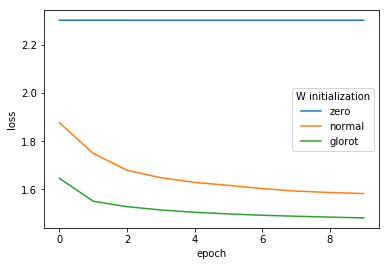

In [9]:
from matplotlib import pyplot as plt
plt.plot(range(0, 10), z_loss, label="zero")
plt.plot(range(0, 10), n_loss, label="normal")
plt.plot(range(0, 10), g_loss, label="glorot")
plt.legend(title="W initialization")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

## Hyperparameter Search

In [9]:
print("{:^10s} | {:^10s} | {:^10s} | {:^10s}".format("hidden 1", "hidden 2",
                                                     "lr", "accuracy"))
print(49 * "-")
best_model = None
best_acc = -1
for h1 in [400, 200, 100]:
    for h2 in [200, 100, 50]:
        for l in [1e-1, 1e-2, 1e-3]:
            clf = Classifier(hidden_dims=(h1, h2))
            clf.initialize_weights("glorot")
            clf.train(x_train, y_train, epochs=10, lr=l, verbose=False)
            loss, acc = clf.test(x_valid, y_valid)
            if acc > best_acc:
                best_acc = acc
                best_model = clf
            print("{:^10d} | {:^10d} | {:^10g} | {:^10.1%}".format(
                h1, h2, l, acc))

 hidden 1  |  hidden 2  |     lr     |  accuracy 
-------------------------------------------------
   400     |    200     |    0.1     |    9.9%   
   400     |    200     |    0.01    |   97.9%   
   400     |    200     |   0.001    |   97.7%   
   400     |    100     |    0.1     |    9.8%   
   400     |    100     |    0.01    |   98.0%   
   400     |    100     |   0.001    |   97.9%   
   400     |     50     |    0.1     |    9.8%   
   400     |     50     |    0.01    |   97.5%   
   400     |     50     |   0.001    |   97.9%   
   200     |    200     |    0.1     |   10.2%   
   200     |    200     |    0.01    |   97.8%   
   200     |    200     |   0.001    |   97.7%   
   200     |    100     |    0.1     |   11.2%   
   200     |    100     |    0.01    |   97.9%   
   200     |    100     |   0.001    |   97.5%   
   200     |     50     |    0.1     |   10.4%   
   200     |     50     |    0.01    |   97.2%   
   200     |     50     |   0.001    |   97.6%   


In [10]:
print("Accuracy of the model on the 10000 test images: {:3.1%}".format(clf.test(x_test, y_test)[1]))

Accuracy of the model on the 10000 test images: 97.2%


## Validate Gradients using Finite Difference

In [11]:
clf = Classifier(hidden_dims=(100,50))
clf.initialize_weights("glorot")
clf.train(x_train, y_train, epochs=10, verbose=False)

In [13]:
x, y = x_train[0], y_train[0]
clf.backward(clf.forward(x), y)
mean_abs_delta, max_abs_delta = [], []
N_values = [i * 10**exp for exp in range(0, 3) for i in range(1, 10)]
layer = 1
for N in N_values:
    delta = []
    for i, (W, gW) in enumerate(zip(clf.weights[layer], clf.grad_w[layer])):
        for j, (w, gw) in enumerate(zip(W, gW)):
            if len(clf.weights[layer]) * i + j > 10:
                break
            clf.weights[layer][i][j] = w + (1.0 / N)
            loss1 = clf.loss(clf.forward(x), y)
            clf.weights[layer][i][j] = w - (1.0 / N)
            loss2 = clf.loss(clf.forward(x), y)
            clf.weights[layer][i][j] = w
            estimate_grad = (loss1 - loss2) / (2.0 / N)
            delta.append(abs(estimate_grad - gw))
    max_abs_delta.append(np.max(delta))
    mean_abs_delta.append(np.mean(delta))

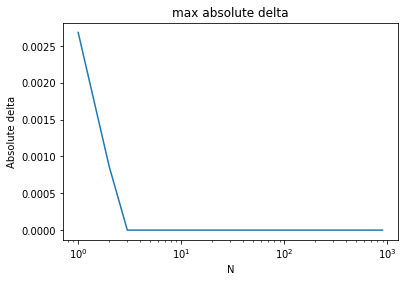

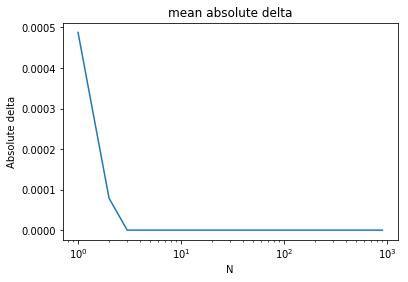

In [14]:
from matplotlib import pyplot as plt

plt.semilogx(N_values, max_abs_delta)
plt.title("max absolute delta")
plt.xlabel("N")
plt.ylabel("Absolute delta")
plt.show()

plt.semilogx(N_values, mean_abs_delta)
plt.title("mean absolute delta")
plt.xlabel("N")
plt.ylabel("Absolute delta")
plt.show()